In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__, hub.__version__)

2.6.0 0.12.0


## data preprocessing

* unzipping zip files 
* turning csv file into pandas dataframe





In [2]:
# from zipfile import ZipFile

# with ZipFile('../data/dog_vision_data/train/train.zip', 'r') as zipObj:
   
#    zipObj.extractall('../data/dog_vision_data/train/') 


# with ZipFile('../data/dog_vision_data/test/test.zip', 'r') as zipObj:
   
#    zipObj.extractall('../data/dog_vision_data/test/') 


# with ZipFile('../data/dog_vision_data/sample_submission/sample_submission.csv.zip', 'r') as zipObj:
   
#    zipObj.extractall('../data/dog_vision_data/sample_submission/') 

In [3]:
labels_csv = pd.read_csv("../data/dog_vision_data/labels.csv")

* identifying amount of pictures we have for each breed and visualising it

<AxesSubplot:>

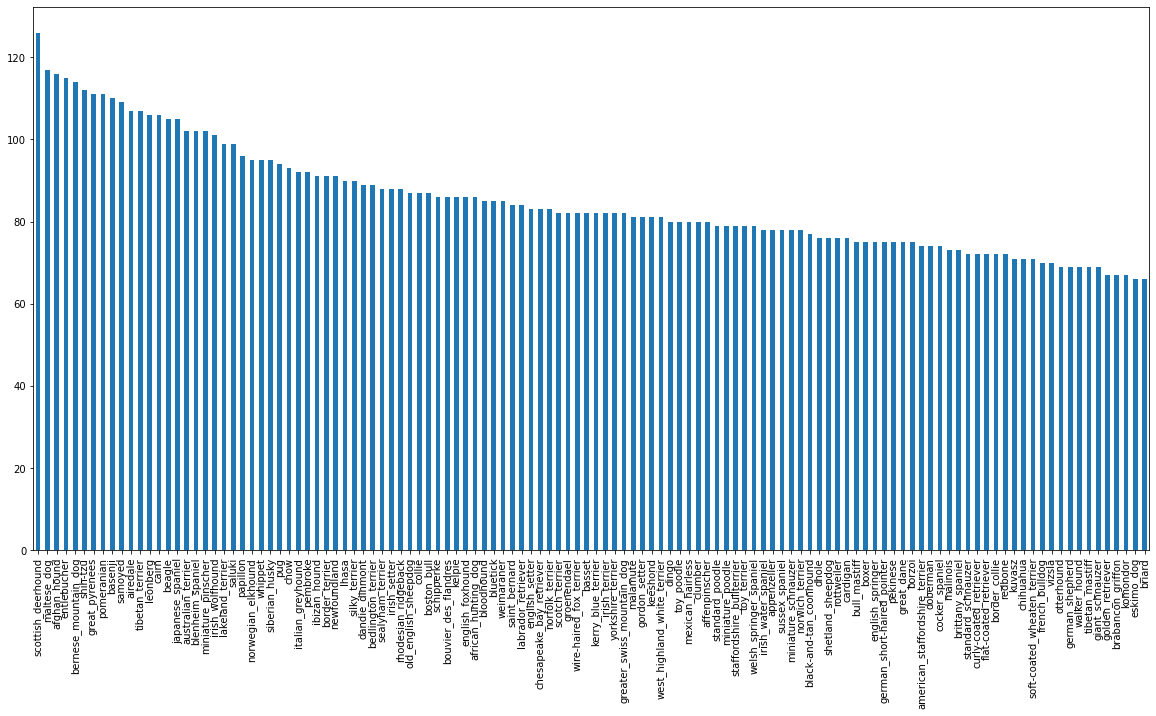

In [4]:
%matplotlib inline
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

* create file paths for each image
* check whether the amounts match

In [5]:
from IPython.display import Image

filenames = ['../data/dog_vision_data/train/' + fname + '.jpg' for fname in labels_csv['id']]

In [6]:
import os

if len(os.listdir("../data/dog_vision_data/train/"))-1 == len(filenames):
  #-1 because extracted zip file remains in the same folder
  print('Filenames amounts match')
else:
  print('Filenames amounts do not match')

Filenames amounts match


## cute dog


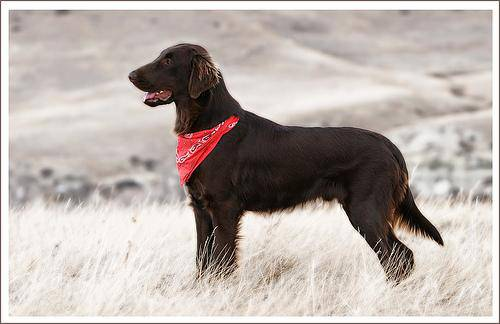

In [7]:
Image(filenames[1011])

In [8]:
    # convert labels column to NumPy array
import numpy as np
labels = labels_csv["breed"].to_numpy()
    # find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [9]:
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [10]:
    # turing labels into boolean arrays
bool_labels = [i == unique_breeds for i in labels]
bool_labels[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [11]:
len(bool_labels) == len(labels)

True

## creating validation set

starting off with 2000 images for experimentation and validation before moving on to large scale model


In [12]:
X = filenames
y = bool_labels
IM_NUM = 2000

In [13]:
from sklearn.model_selection import train_test_split
    #splitting data into training and validation sets and setting up a random state within
X_train, X_val, y_train, y_val = train_test_split(X[:IM_NUM],
                                                  y[:IM_NUM],
                                                  test_size = 0.2,
                                                  random_state = 42)
len(X_train), len(X_val)

(1600, 400)

## image preprocessing

In [14]:
IMG_SIZE = 224
def process_image(image_path, img_size = 224):
  '''
  Takes an image file path and turns it into a Tensor.
  '''
  image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (RBG)
  image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
    
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Turning data into batches

Friends dont let friends use minibatches larger than 32.



In [15]:
    # creating tuples with images and associated labels
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label
  '''
  image = process_image(image_path)
  return image, label

In [16]:
BATCH_SIZE = 32


def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    '''
    creates data batches fom X images and y label pairs.
    shuffles data when it's training data and doesn't when it's validation data.
    accepts test data as input even without labels.
    '''
    
    if test_data:
        print('creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
  
    elif valid_data:
        print('creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                   tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print('creating training data batches...')
        
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels        
        data = data.shuffle(buffer_size=len(x))
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [17]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

creating training data batches...
creating validation data batches...


In [18]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## visualising batches

In [19]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_img):

    plt.figure(figsize=(15,10))

    for i in range(num_img):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis('off')


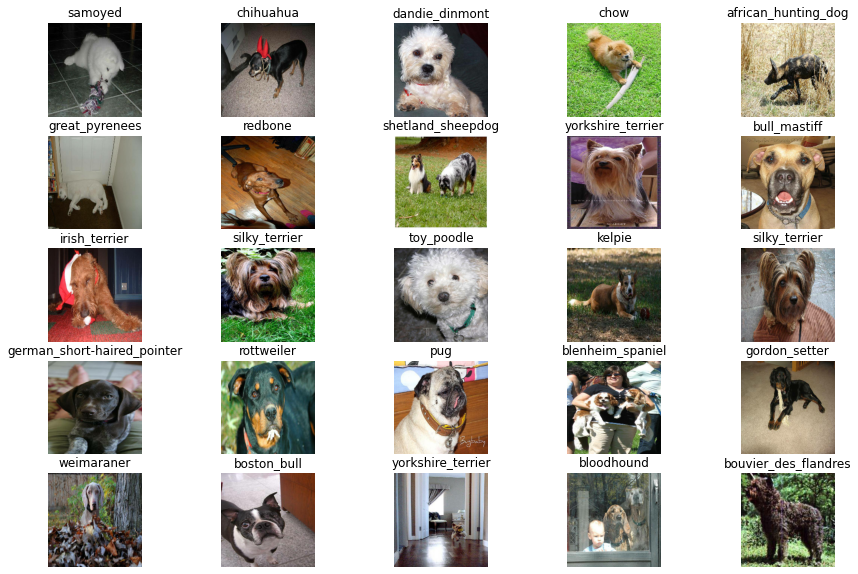

In [20]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images,train_labels, 25)

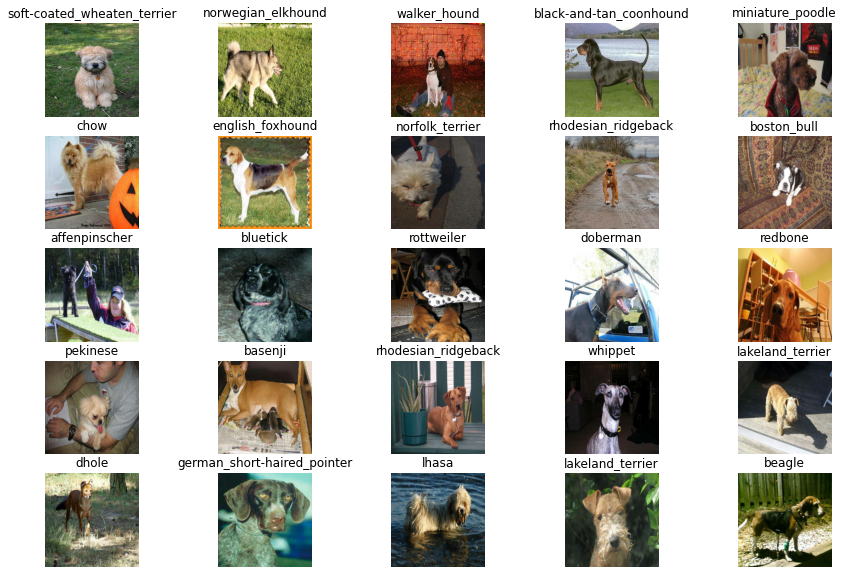

In [21]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_images(val_images, val_labels, 25)

## creating and training a model

In [22]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

In [23]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print('Building model with', MODEL_URL)

    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units = output_shape,
                              activation = 'softmax')
    ])

    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )

    model.build(INPUT_SHAPE)

    return model


In [24]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [25]:
%load_ext tensorboard

In [26]:
import datetime 

def create_tensorboard_callback():

    logdir = os.path.join('../data/logs',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))    
    return tf.keras.callbacks.TensorBoard(logdir)
     

In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              patience = 3)

In [28]:
NUM_EPOCHS = 100

In [29]:
def train_model():
    '''
    Trains a given model and returns the trained version.
    '''
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
                epochs=NUM_EPOCHS,
                validation_data=val_data,
                validation_freq=1, # check validation metrics every epoch
                callbacks=[tensorboard, early_stop])
    
    return model

In [30]:
%%time
model = train_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
50/50 [==============================] - 45s 776ms/step - loss: 3.6187 - accuracy: 0.2488 - val_loss: 1.8586 - val_accuracy: 0.5800
Epoch 2/100
50/50 [==============================] - 36s 715ms/step - loss: 0.8428 - accuracy: 0.8306 - val_loss: 1.1331 - val_accuracy: 0.6950
Epoch 3/100
50/50 [==============================] - 36s 728ms/step - loss: 0.3237 - accuracy: 0.9656 - val_loss: 0.9927 - val_accuracy: 0.7250
Epoch 4/100
50/50 [==============================] - 36s 727ms/step - loss: 0.1753 - accuracy: 0.9887 - val_loss: 0.9301 - val_accuracy: 0.7450
Epoch 5/100
50/50 [==============================] - 36s 719ms/step - loss: 0.1093 - accuracy: 0.9956 - val_loss: 0.8984 - val_accuracy: 0.7400
Epoch 6/100
50/50 [==============================] - 36s 719ms/step - loss: 0.0773 - accuracy: 1.0000 - val_loss: 0.8748 - val_accuracy: 0.7475
Epoch 7/100
50/50 [=========================

## full data model

In [33]:
full_data =  create_data_batches(X, y)

creating training data batches...


In [35]:
full_model = create_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [38]:
full_model_tensorboard = create_tensorboard_callback()

full_model_early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

In [39]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stop])

Epoch 1/100
320/320 [==============================] - 194s 588ms/step - loss: 1.3329 - accuracy: 0.6736
Epoch 2/100
320/320 [==============================] - 181s 564ms/step - loss: 0.3977 - accuracy: 0.8841
Epoch 3/100
320/320 [==============================] - 183s 573ms/step - loss: 0.2354 - accuracy: 0.9366
Epoch 4/100
320/320 [==============================] - 203s 633ms/step - loss: 0.1558 - accuracy: 0.9609
Epoch 5/100
320/320 [==============================] - 198s 619ms/step - loss: 0.1057 - accuracy: 0.9783
Epoch 6/100
320/320 [==============================] - 199s 621ms/step - loss: 0.0753 - accuracy: 0.9862
Epoch 7/100
320/320 [==============================] - 199s 622ms/step - loss: 0.0588 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 200s 625ms/step - loss: 0.0448 - accuracy: 0.9957
Epoch 9/100
320/320 [==============================] - 204s 636ms/step - loss: 0.0373 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] -

In [47]:
test_path = '../data/dog_vision_data/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['../data/dog_vision_data/test/000621fb3cbb32d8935728e48679680e.jpg',
 '../data/dog_vision_data/test/00102ee9d8eb90812350685311fe5890.jpg',
 '../data/dog_vision_data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 '../data/dog_vision_data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 '../data/dog_vision_data/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 '../data/dog_vision_data/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 '../data/dog_vision_data/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 '../data/dog_vision_data/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 '../data/dog_vision_data/test/002f80396f1e3db687c5932d7978b196.jpg',
 '../data/dog_vision_data/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [48]:
len(test_filenames)

10357

In [49]:
test_data = create_data_batches(test_filenames, test_data=True)

creating test data batches...


In [51]:
test_predictions = full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 238s 730ms/step


In [52]:
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [53]:
test_path = '../data/dog_vision_data/test/'
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.069295e-13,2.309166e-13,1.056581e-15,1.488149e-15,7.023733e-15,1.472953e-13,4.033539e-18,1.375634e-14,1.456368e-15,...,3.594237e-14,1.164458e-15,7.409148e-16,2.222296e-17,6.697058e-15,1.277211e-14,4.103414e-15,2.338501e-15,1.577133e-11,1.968647e-12
1,00102ee9d8eb90812350685311fe5890,9.488180e-07,2.748158e-07,5.379907e-10,4.981535e-10,9.385051e-08,1.258541e-09,5.143515e-08,5.245662e-08,1.128508e-09,...,2.693628e-10,4.110016e-08,2.358615e-10,7.837104e-07,1.436643e-09,8.713638e-09,5.404511e-05,1.593235e-12,1.109403e-08,3.364347e-11
2,0012a730dfa437f5f3613fb75efcd4ce,2.719850e-12,7.973465e-08,1.521268e-10,1.857254e-12,6.318740e-12,4.513350e-10,2.973923e-13,5.952714e-14,3.398846e-10,...,2.431624e-13,2.534075e-13,8.486476e-09,1.043672e-07,5.278566e-09,2.861970e-09,9.831637e-15,3.248362e-08,1.856614e-11,4.188708e-13
3,001510bc8570bbeee98c8d80c8a95ec1,1.724943e-07,1.266842e-08,6.708061e-08,1.350305e-07,1.221255e-05,3.210845e-07,2.697907e-12,3.463458e-10,3.915642e-09,...,4.061467e-07,7.469880e-11,1.251468e-06,1.331749e-10,1.622401e-07,4.279632e-10,5.239864e-18,8.318444e-03,1.074953e-11,4.301369e-09
4,001a5f3114548acdefa3d4da05474c2e,9.762508e-06,1.468116e-06,2.241736e-09,1.625717e-11,5.286719e-11,6.626005e-13,1.617493e-11,6.152164e-10,1.935562e-10,...,4.605212e-09,1.800348e-12,1.664380e-12,6.437412e-13,2.340948e-11,3.058668e-11,9.819159e-13,1.452834e-08,3.239075e-11,1.398643e-09


In [55]:
preds_df.to_csv("../data/dog_vision_data/submission_1_mobilienetV2_adam.csv",
                 index=False)